In [12]:
# =============================================================
# DCIT 411: Bioinformatics — Sequence Alignment with Biopython
# Student  : Amoako Albert | 11227686
# Module   : pairwise_alignment.py
# Purpose  : Implement global (Needleman-Wunsch) and local
#            (Smith-Waterman) pairwise alignment using Biopython's
#            PairwiseAligner. Loads cleaned data from config,
#            saves results to configured directories.
# =============================================================



In [13]:
import os
import sys
import time
import logging
from pathlib import Path
from itertools import combinations

import numpy as np
import matplotlib.pyplot as plt
from Bio import Align, SeqIO
from Bio.Align import substitution_matrices
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

# ── Import config for directory paths ─────────────────────────
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
sys.path.append(os.path.abspath(".."))
import config

# ── Logging setup (falls back to print if needed) ─────────────
try:
    logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s [%(levelname)s] %(message)s",
        datefmt="%H:%M:%S",
        handlers=[
            logging.FileHandler(os.path.join(config.RESULTS_DIR, "alignment.log")),
            logging.StreamHandler()
        ]
    )
    log = logging.getLogger(__name__)
except Exception:
    log = None

def _log(msg, level="info"):
    """Internal logger wrapper that falls back to print."""
    if log and hasattr(log, level):
        getattr(log, level)(msg)
    else:
        print(f"[{level.upper()}] {msg}")




In [14]:
# =============================================================
# SECTION 1: Aligner Factory
# =============================================================

def build_aligner(
    mode: str           = "global",
    matrix_name: str    = "BLOSUM62",
    open_gap: float     = -10.0,
    extend_gap: float   = -0.5,
) -> Align.PairwiseAligner:
    """
    Construct and configure a Biopython PairwiseAligner.

    Parameters
    ----------
    mode        : 'global' → Needleman-Wunsch | 'local' → Smith-Waterman
    matrix_name : Substitution matrix name (BLOSUM62, PAM250, etc.)
    open_gap    : Gap opening penalty (negative)
    extend_gap  : Gap extension penalty (negative)

    Returns
    -------
    Align.PairwiseAligner configured and ready to use.
    """
    aligner = Align.PairwiseAligner()
    aligner.mode = mode

    try:
        aligner.substitution_matrix = substitution_matrices.load(matrix_name)
        _log(f"Loaded substitution matrix: {matrix_name}")
    except Exception as e:
        _log(f"Could not load '{matrix_name}': {e}. Falling back to BLOSUM62.", "warning")
        aligner.substitution_matrix = substitution_matrices.load("BLOSUM62")

    aligner.open_gap_score   = open_gap
    aligner.extend_gap_score = extend_gap
    return aligner




In [15]:
# =============================================================
# SECTION 2: Core Alignment Functions
# =============================================================

def global_align(seq1: str, seq2: str, matrix_name: str = "BLOSUM62",
                 open_gap: float = -10.0, extend_gap: float = -0.5) -> Align.Alignment:
    """Perform global pairwise alignment (Needleman-Wunsch)."""
    aligner = build_aligner("global", matrix_name, open_gap, extend_gap)
    alignments = aligner.align(seq1, seq2)
    best = alignments[0]
    _log(f"[GLOBAL | {matrix_name}] Score={best.score:.2f} | Lengths: {len(seq1)} vs {len(seq2)}")
    return best


def local_align(seq1: str, seq2: str, matrix_name: str = "BLOSUM62",
                open_gap: float = -10.0, extend_gap: float = -0.5) -> Align.Alignment:
    """Perform local pairwise alignment (Smith-Waterman)."""
    aligner = build_aligner("local", matrix_name, open_gap, extend_gap)
    alignments = aligner.align(seq1, seq2)
    best = alignments[0]
    _log(f"[LOCAL | {matrix_name}] Score={best.score:.2f} | Lengths: {len(seq1)} vs {len(seq2)}")
    return best




In [16]:
# =============================================================
# SECTION 3: Scoring & Metrics
# =============================================================

def compute_metrics(alignment: Align.Alignment) -> dict:
    """Calculate standard alignment quality metrics."""
    aligned_str = str(alignment)
    lines = aligned_str.strip().split("\n")
    seq_lines = [l for l in lines if l and not l.startswith(" ")]
    
    if len(seq_lines) >= 2:
        row1, row2 = seq_lines[0], seq_lines[-1]
    else:
        coords = alignment.aligned
        row1 = "".join(str(alignment.target[s:e]) for s, e in coords[0])
        row2 = "".join(str(alignment.query[s:e]) for s, e in coords[1])

    length = max(len(row1), len(row2))
    matches = sum(1 for a, b in zip(row1, row2) if a == b and a != "-")
    gaps = row1.count("-") + row2.count("-")
    mismatches = length - matches - gaps
    identity = (matches / length * 100) if length > 0 else 0.0
    gap_frac = (gaps / length * 100) if length > 0 else 0.0

    return {
        "score": alignment.score, "length": length, "matches": matches,
        "mismatches": mismatches, "gaps": gaps,
        "identity": round(identity, 2), "gap_frac": round(gap_frac, 2),
    }


def print_metrics(metrics: dict, label: str = "") -> None:
    """Pretty-print alignment metrics."""
    pad = f"[{label}] " if label else ""
    print(f"\n  {pad}Alignment Statistics")
    print(f"  {'─' * 40}")
    print(f"  {'Alignment Score':<24}: {metrics['score']:.2f}")
    print(f"  {'Alignment Length':<24}: {metrics['length']}")
    print(f"  {'Identical Matches':<24}: {metrics['matches']}")
    print(f"  {'Mismatches':<24}: {metrics['mismatches']}")
    print(f"  {'Gaps':<24}: {metrics['gaps']}")
    print(f"  {'Identity':<24}: {metrics['identity']:.2f}%")
    print(f"  {'Gap Fraction':<24}: {metrics['gap_frac']:.2f}%")
    print(f"  {'─' * 40}")


def print_alignment(alignment: Align.Alignment, width: int = 60) -> None:
    """Print a human-readable alignment with match indicators."""
    aln_str = str(alignment)
    print(f"\n{'─' * 65}")
    print(f"  Score : {alignment.score:.2f}")
    print(f"{'─' * 65}")
    for line in aln_str.strip().split("\n"):
        for i in range(0, len(line), width):
            print(f"  {line[i:i+width]}")
    print(f"{'─' * 65}\n")




In [17]:
# =============================================================
# SECTION 4: Data Loading (Config-Integrated)
# =============================================================

def load_cleaned_sequences(
    filename: str = None,
    directory: str = None,
    fmt: str = "fasta"
) -> list[SeqRecord]:
    """
    Load cleaned sequences from the configured processed data directory.
    
    Parameters
    ----------
    filename  : Name of the FASTA file in PROCESSED_DATA_DIR
    directory : Override directory (default: config.PROCESSED_DATA_DIR)
    fmt       : File format (default: 'fasta')
    
    Returns
    -------
    list[SeqRecord] : Loaded and cleaned sequence records
    """
    dir_path = directory or config.PROCESSED_DATA_DIR
    file_path = os.path.join(dir_path, filename) if filename else dir_path
    
    if filename and not os.path.exists(file_path):
        raise FileNotFoundError(f"Cleaned file not found: {file_path}")
    
    if filename:
        records = list(SeqIO.parse(file_path, fmt))
        _log(f"Loaded {len(records)} cleaned sequence(s) from: {filename}")
    else:
        # Load all FASTA files in directory
        records = []
        for f in Path(dir_path).glob("*.fasta"):
            records.extend(SeqIO.parse(f, fmt))
        _log(f"Loaded {len(records)} cleaned sequence(s) from: {dir_path}")
    
    for r in records:
        _log(f"  → {r.id:<30} length={len(r.seq):>6}")
    return records


def load_single_cleaned_sequence(filename: str, directory: str = None) -> SeqRecord:
    """Load exactly one cleaned sequence; raises error if count != 1."""
    records = load_cleaned_sequences(filename, directory)
    if len(records) != 1:
        raise ValueError(f"Expected 1 sequence, found {len(records)} in '{filename}'")
    return records[0]




In [18]:
# =============================================================
# SECTION 5: Saving Results (Config-Integrated)
# =============================================================

def save_alignment(
    alignment: Align.Alignment,
    seq1_id: str,
    seq2_id: str,
    filename: str = None,
    directory: str = None,
    fmt: str = "aln"
) -> str:
    """
    Save alignment to configured results directory with metadata header.
    
    Returns
    -------
    str : Path to saved file
    """
    dir_path = directory or config.ALIGNMENTS_DIR
    Path(dir_path).mkdir(parents=True, exist_ok=True)
    
    if filename is None:
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        filename = f"{seq1_id}_vs_{seq2_id}_{timestamp}.{fmt}"
    
    filepath = os.path.join(dir_path, filename)
    metrics = compute_metrics(alignment)
    
    with open(filepath, "w") as f:
        f.write("# =========================================\n")
        f.write("# DCIT 411 Pairwise Alignment Output\n")
        f.write(f"# Student : Amoako Albert | 11227686\n")
        f.write(f"# Seq1    : {seq1_id}\n")
        f.write(f"# Seq2    : {seq2_id}\n")
        f.write(f"# Score   : {metrics['score']:.2f}\n")
        f.write(f"# Identity: {metrics['identity']:.2f}%\n")
        f.write(f"# Gaps    : {metrics['gap_frac']:.2f}%\n")
        f.write(f"# Length  : {metrics['length']}\n")
        f.write("# =========================================\n\n")
        f.write(str(alignment))
    
    _log(f"Alignment saved → {filepath}")
    return filepath


def save_metrics(
    metrics_list: list[dict],
    filename: str = "alignment_metrics.csv",
    directory: str = None
) -> str:
    """Save alignment metrics to CSV in configured metrics directory."""
    dir_path = directory or config.METRICS_DIR
    Path(dir_path).mkdir(parents=True, exist_ok=True)
    filepath = os.path.join(dir_path, filename)
    
    import csv
    if not metrics_list:
        _log("No metrics to save", "warning")
        return filepath
    
    with open(filepath, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=metrics_list[0].keys())
        writer.writeheader()
        writer.writerows(metrics_list)
    
    _log(f"Metrics saved → {filepath}")
    return filepath


def save_figure(fig, filename: str, directory: str = None, dpi: int = 200) -> str:
    """Save matplotlib figure to configured figures directory."""
    dir_path = directory or config.FIGURES_DIR
    Path(dir_path).mkdir(parents=True, exist_ok=True)
    filepath = os.path.join(dir_path, filename)
    
    fig.savefig(filepath, dpi=dpi, bbox_inches="tight", 
                facecolor=fig.get_facecolor())
    _log(f"Figure saved → {filepath}")
    return filepath




In [19]:
# =============================================================
# SECTION 6: Parameter Experiments
# =============================================================

def experiment_matrices(seq1: str, seq2: str, matrices: list = None,
                        mode: str = "global") -> list[dict]:
    """Run alignment with multiple substitution matrices."""
    if matrices is None:
        matrices = ["BLOSUM45", "BLOSUM62", "BLOSUM80", "PAM30", "PAM250"]
    
    results = []
    print(f"\n  {'Matrix':<12} {'Score':>10} {'Identity':>10} {'Gaps':>8}")
    print(f"  {'─' * 46}")
    
    for mat in matrices:
        try:
            fn = global_align if mode == "global" else local_align
            aln = fn(seq1, seq2, matrix_name=mat)
            m = compute_metrics(aln)
            m["matrix"] = mat
            results.append(m)
            print(f"  {mat:<12} {m['score']:>10.2f} {m['identity']:>9.2f}% {m['gaps']:>8}")
        except Exception as e:
            _log(f"Skipped {mat}: {e}", "warning")
    return results


def experiment_gap_penalties(seq1: str, seq2: str, 
                             open_gaps: list = None, extend_gaps: list = None,
                             mode: str = "global", matrix_name: str = "BLOSUM62") -> list[dict]:
    """Run alignment across gap penalty grid."""
    if open_gaps is None: open_gaps = [-5.0, -8.0, -10.0, -12.0]
    if extend_gaps is None: extend_gaps = [-0.2, -0.5, -1.0, -2.0]
    
    results = []
    print(f"\n  {'Open':>7} {'Extend':>8} {'Score':>10} {'Identity':>10} {'Gaps%':>7}")
    print(f"  {'─' * 50}")
    
    for og in open_gaps:
        for eg in extend_gaps:
            fn = global_align if mode == "global" else local_align
            aln = fn(seq1, seq2, matrix_name=matrix_name, open_gap=og, extend_gap=eg)
            m = compute_metrics(aln)
            m.update({"open": og, "extend": eg})
            results.append(m)
            print(f"  {og:>7.1f} {eg:>8.2f} {m['score']:>10.2f} {m['identity']:>9.2f}% {m['gap_frac']:>6.2f}%")
    return results




In [20]:
# =============================================================
# SECTION 7: All-vs-All Pairwise Matrix
# =============================================================

def all_vs_all(records: list[SeqRecord], mode: str = "global",
               matrix_name: str = "BLOSUM62", open_gap: float = -10.0,
               extend_gap: float = -0.5) -> dict:
    """Align every pair and build identity/score matrices."""
    ids = [r.id for r in records]
    n = len(records)
    score_mat = np.zeros((n, n))
    id_mat = np.zeros((n, n))
    raw = []
    
    _log(f"All-vs-All: {n} sequences, {n*(n-1)//2} pairs")
    
    for i, j in combinations(range(n), 2):
        s1, s2 = str(records[i].seq), str(records[j].seq)
        fn = global_align if mode == "global" else local_align
        aln = fn(s1, s2, matrix_name=matrix_name, open_gap=open_gap, extend_gap=extend_gap)
        m = compute_metrics(aln)
        
        score_mat[i, j] = score_mat[j, i] = m["score"]
        id_mat[i, j] = id_mat[j, i] = m["identity"]
        raw.append({"seq1": ids[i], "seq2": ids[j], **m})
        print(f"  {ids[i]:<25} vs {ids[j]:<25} | Score={m['score']:>8.2f} Identity={m['identity']:>5.1f}%")
    
    np.fill_diagonal(id_mat, 100.0)
    return {"ids": ids, "scores": score_mat, "identities": id_mat, "raw_results": raw}




In [21]:
# =============================================================
# SECTION 8: Visualization (Config-Integrated)
# =============================================================

def plot_identity_heatmap(result: dict, filename: str = "identity_heatmap.png",
                          title: str = "Pairwise Identity Matrix (%)",
                          directory: str = None) -> str:
    """Plot and save identity heatmap to configured figures directory."""
    ids = result["ids"]
    id_matrix = result["identities"]
    n = len(ids)
    
    fig, ax = plt.subplots(figsize=(max(6, n * 1.2), max(5, n)))
    fig.patch.set_facecolor("#0d1117")
    ax.set_facecolor("#0d1117")
    
    im = ax.imshow(id_matrix, cmap="YlOrRd", vmin=0, vmax=100, aspect="auto")
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Identity (%)", color="white", fontsize=10)
    cbar.ax.yaxis.set_tick_params(color="white")
    plt.setp(cbar.ax.yaxis.get_ticklabels(), color="white")
    
    short_ids = [i.split(".")[0][:15] for i in ids]
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xticklabels(short_ids, rotation=45, ha="right", color="white", fontsize=9)
    ax.set_yticklabels(short_ids, color="white", fontsize=9)
    
    for i in range(n):
        for j in range(n):
            val = id_matrix[i, j]
            color = "black" if val > 60 else "white"
            ax.text(j, i, f"{val:.1f}", ha="center", va="center", 
                    fontsize=8, color=color, fontweight="bold")
    
    ax.set_title(title, color="white", fontsize=13, pad=14, fontweight="bold")
    ax.tick_params(colors="white")
    for spine in ax.spines.values():
        spine.set_edgecolor("#2d3748")
    
    plt.tight_layout()
    save_path = save_figure(fig, filename, directory)
    plt.show()
    plt.close()
    return save_path


def plot_matrix_comparison(matrix_results: list[dict], 
                           filename: str = "matrix_comparison.png",
                           directory: str = None) -> str:
    """Bar chart comparing scores/identity across matrices."""
    matrices = [r["matrix"] for r in matrix_results]
    scores = [r["score"] for r in matrix_results]
    identities = [r["identity"] for r in matrix_results]
    
    x = np.arange(len(matrices))
    width = 0.38
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
    fig.patch.set_facecolor("#0d1117")
    bar_colors = ["#4a9eff", "#2ecc71", "#f5a623", "#e94560", "#b84fff"]
    
    for ax in (ax1, ax2):
        ax.set_facecolor("#0d1117")
        ax.tick_params(colors="white")
        for spine in ax.spines.values():
            spine.set_edgecolor("#2d3748")
        ax.yaxis.label.set_color("white")
        ax.xaxis.label.set_color("white")
        ax.title.set_color("white")
    
    bars1 = ax1.bar(x, scores, color=bar_colors[:len(matrices)], edgecolor="#2d3748")
    ax1.set_xticks(x)
    ax1.set_xticklabels(matrices, color="white", rotation=20, ha="right")
    ax1.set_title("Alignment Score by Matrix", fontweight="bold")
    ax1.set_ylabel("Score")
    for bar, val in zip(bars1, scores):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 f"{val:.1f}", ha="center", va="bottom", color="white", fontsize=9)
    
    bars2 = ax2.bar(x, identities, color=bar_colors[:len(matrices)], edgecolor="#2d3748")
    ax2.set_xticks(x)
    ax2.set_xticklabels(matrices, color="white", rotation=20, ha="right")
    ax2.set_title("Percent Identity by Matrix", fontweight="bold")
    ax2.set_ylabel("Identity (%)")
    ax2.set_ylim(0, 110)
    for bar, val in zip(bars2, identities):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 f"{val:.1f}%", ha="center", va="bottom", color="white", fontsize=9)
    
    fig.suptitle("Substitution Matrix Comparison", color="white", fontsize=13, fontweight="bold", y=1.02)
    plt.tight_layout()
    save_path = save_figure(fig, filename, directory)
    plt.show()
    plt.close()
    return save_path




00:11:46 [INFO] Loaded 4 cleaned sequence(s) from: hemoglobin_clean.fasta
00:11:46 [INFO]   → NP_000549.1                    length=   142
00:11:46 [INFO]   → NP_001009042.1                 length=  1272
00:11:46 [INFO]   → NP_032246.2                    length=   147
00:11:46 [INFO]   → NP_036706.1                    length=  1482
00:11:46 [INFO] Loaded substitution matrix: BLOSUM62
00:11:46 [INFO] [GLOBAL | BLOSUM62] Score=-465.00 | Lengths: 142 vs 1272
00:11:46 [INFO] Alignment saved → c:\Users\infom\Desktop\bioinfo\ass1\results\alignments\global_nw_blosum62.aln
00:11:46 [INFO] Loaded substitution matrix: BLOSUM62
00:11:46 [INFO] [LOCAL | BLOSUM62] Score=38.00 | Lengths: 142 vs 1272
00:11:46 [INFO] Alignment saved → c:\Users\infom\Desktop\bioinfo\ass1\results\alignments\local_sw_blosum62.aln
00:11:46 [INFO] Loaded substitution matrix: BLOSUM45
00:11:46 [INFO] [GLOBAL | BLOSUM45] Score=-389.50 | Lengths: 142 vs 1272
00:11:46 [INFO] Loaded substitution matrix: BLOSUM62
00:11:46 [INFO]


══════════════════════════════════════════════════════════════════════
  DCIT 411 — Pairwise Alignment Module (Config-Integrated)
  Student: Amoako Albert | ID: 11227686
══════════════════════════════════════════════════════════════════════

[1] GLOBAL ALIGNMENT — Needleman-Wunsch (BLOSUM62)
──────────────────────────────────────────────────────────────────────

─────────────────────────────────────────────────────────────────
  Score : -465.00
─────────────────────────────────────────────────────────────────
  target            0 MVL-------------------------------------
  --------------------
                    0 |.|-------------------------------------
  --------------------
  query             0 MDLFDFFRDWDLEQQCHYEQDRSALKKREWERRNQEVQQE
  DDLFSSGFDLFGEPYKTNKG
  target            3 ----------------------------------------
  ----------SPADKTNV--
                   60 ----------------------------------------
  ----------.|..|...--
  query            60 DALANRVQNTLGNYDEMKDLLTNHSNQNHLVG

00:11:47 [INFO] Figure saved → c:\Users\infom\Desktop\bioinfo\ass1\results\figures\matrix_comparison.png


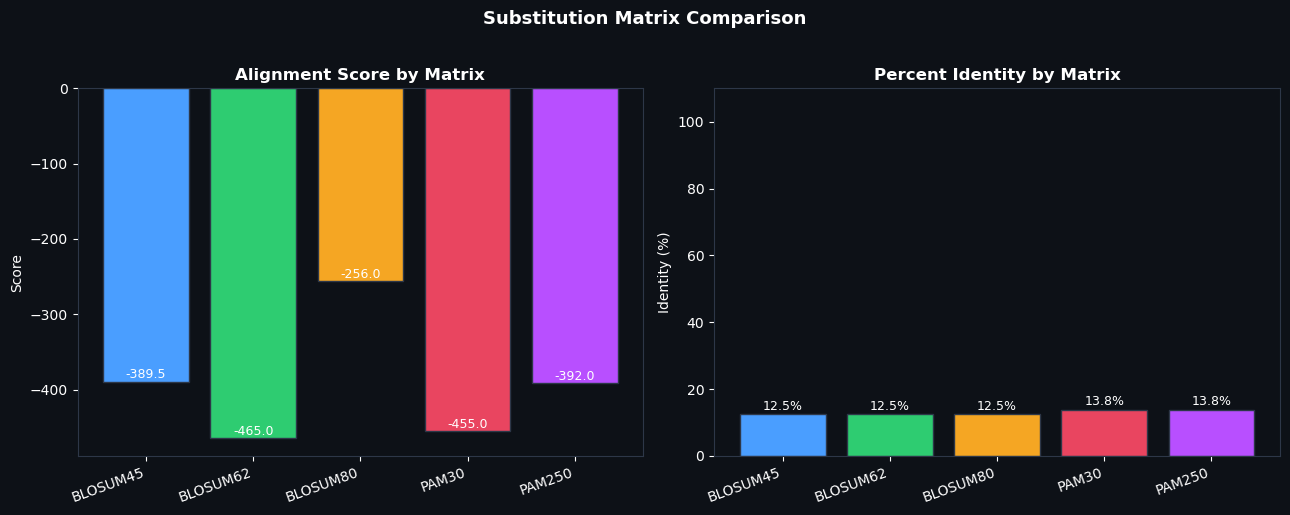

00:11:47 [INFO] Loaded substitution matrix: BLOSUM62
00:11:47 [INFO] [GLOBAL | BLOSUM62] Score=26.00 | Lengths: 142 vs 1272
00:11:47 [INFO] Loaded substitution matrix: BLOSUM62
00:11:47 [INFO] [GLOBAL | BLOSUM62] Score=-300.00 | Lengths: 142 vs 1272
00:11:47 [INFO] Loaded substitution matrix: BLOSUM62
00:11:47 [INFO] [GLOBAL | BLOSUM62] Score=-840.00 | Lengths: 142 vs 1272
00:11:47 [INFO] Loaded substitution matrix: BLOSUM62
00:11:47 [INFO] [GLOBAL | BLOSUM62] Score=-1903.00 | Lengths: 142 vs 1272
00:11:47 [INFO] Loaded substitution matrix: BLOSUM62
00:11:47 [INFO] [GLOBAL | BLOSUM62] Score=-83.20 | Lengths: 142 vs 1272
00:11:47 [INFO] Loaded substitution matrix: BLOSUM62
00:11:47 [INFO] [GLOBAL | BLOSUM62] Score=-415.00 | Lengths: 142 vs 1272
00:11:47 [INFO] Loaded substitution matrix: BLOSUM62
00:11:47 [INFO] [GLOBAL | BLOSUM62] Score=-966.00 | Lengths: 142 vs 1272
00:11:47 [INFO] Loaded substitution matrix: BLOSUM62
00:11:47 [INFO] [GLOBAL | BLOSUM62] Score=-2060.00 | Lengths: 142 v


[4] EXPERIMENT — Gap Penalty Grid Search
──────────────────────────────────────────────────────────────────────

     Open   Extend      Score   Identity   Gaps%
  ──────────────────────────────────────────────────
     -5.0    -0.20      26.00     12.50%  62.50%
     -5.0    -0.50    -300.00     13.75%  62.50%
     -5.0    -1.00    -840.00     13.75%  62.50%
     -5.0    -2.00   -1903.00     13.75%  68.75%
     -8.0    -0.20     -83.20     12.50%  62.50%
     -8.0    -0.50    -415.00     12.50%  62.50%
     -8.0    -1.00    -966.00     13.75%  62.50%
     -8.0    -2.00   -2060.00     13.75%  62.50%
    -10.0    -0.20    -131.40     12.50%  71.25%
    -10.0    -0.50    -465.00     12.50%  71.25%
    -10.0    -1.00   -1021.00     12.50%  71.25%
    -10.0    -2.00   -2126.00     13.75%  62.50%
    -12.0    -0.20    -174.20     13.75%  71.25%
    -12.0    -0.50    -507.50     13.75%  71.25%
    -12.0    -1.00   -1063.00     13.75%  71.25%
    -12.0    -2.00   -2173.00     13.75%  71.25%


00:11:47 [INFO] Figure saved → c:\Users\infom\Desktop\bioinfo\ass1\results\figures\pairwise_identity_heatmap.png


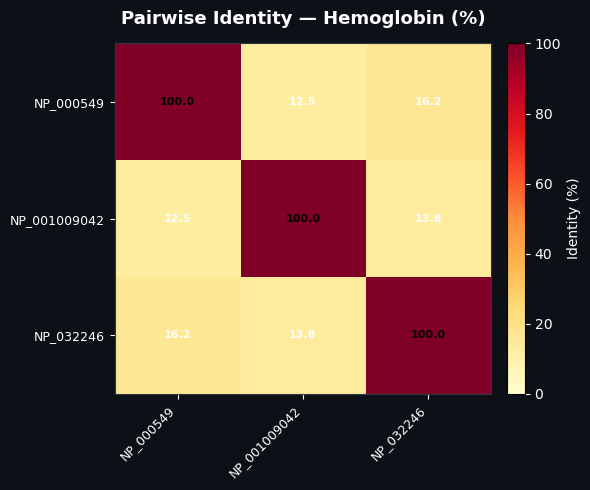

00:11:48 [INFO] Metrics saved → c:\Users\infom\Desktop\bioinfo\ass1\results\metrics\all_vs_all_metrics.csv



✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
  All experiments complete.
  Alignments saved to: c:\Users\infom\Desktop\bioinfo\ass1\results\alignments
  Figures saved to:    c:\Users\infom\Desktop\bioinfo\ass1\results\figures
  Metrics saved to:    c:\Users\infom\Desktop\bioinfo\ass1\results\metrics
══════════════════════════════════════════════════════════════════════


In [22]:
# =============================================================
# MAIN — Demo with Config-Integrated I/O
# =============================================================

if __name__ == "__main__":
    print("\n" + "═" * 70)
    print("  DCIT 411 — Pairwise Alignment Module (Config-Integrated)")
    print("  Student: Amoako Albert | ID: 11227686")
    print("═" * 70)
    
    # ── Load cleaned sequences from configured directory ───────
    try:
        cleaned_records = load_cleaned_sequences("hemoglobin_clean.fasta")
        if len(cleaned_records) >= 2:
            seq1_rec, seq2_rec = cleaned_records[0], cleaned_records[1]
            seq1, seq2 = str(seq1_rec.seq), str(seq2_rec.seq)
            id1, id2 = seq1_rec.id, seq2_rec.id
        else:
            # Fallback demo sequences if file not found
            _log("Using fallback demo sequences", "warning")
            seq1 = "MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR"
            seq2 = "MVLSGEDKSNIKAAWGKIGGHGAEYGAEALERMFASFPTTKTYFPHFDVSHGSAQVKAHGKKVAEALTKAVGHLDDLPGALSALSDLHAHKLRVDPVNFKLLSHCLLVTLASHHPADFTPAVHASLDKFLANVSTVLTSKYR"
            id1, id2 = "HBA_HUMAN_DEMO", "HBA_MOUSE_DEMO"
    except FileNotFoundError as e:
        _log(f"Warning: {e}. Using fallback sequences.", "warning")
        seq1 = "MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR"
        seq2 = "MVLSGEDKSNIKAAWGKIGGHGAEYGAEALERMFASFPTTKTYFPHFDVSHGSAQVKAHGKKVAEALTKAVGHLDDLPGALSALSDLHAHKLRVDPVNFKLLSHCLLVTLASHHPADFTPAVHASLDKFLANVSTVLTSKYR"
        id1, id2 = "HBA_HUMAN_DEMO", "HBA_MOUSE_DEMO"
    
    # ── [1] Global Alignment ───────────────────────────────────
    print("\n[1] GLOBAL ALIGNMENT — Needleman-Wunsch (BLOSUM62)")
    print("─" * 70)
    global_aln = global_align(seq1, seq2)
    print_alignment(global_aln)
    m_global = compute_metrics(global_aln)
    print_metrics(m_global, label="Global | BLOSUM62")
    save_alignment(global_aln, id1, id2, filename="global_nw_blosum62.aln")
    
    # ── [2] Local Alignment ────────────────────────────────────
    print("\n[2] LOCAL ALIGNMENT — Smith-Waterman (BLOSUM62)")
    print("─" * 70)
    local_aln = local_align(seq1, seq2)
    print_alignment(local_aln)
    m_local = compute_metrics(local_aln)
    print_metrics(m_local, label="Local | BLOSUM62")
    save_alignment(local_aln, id1, id2, filename="local_sw_blosum62.aln")
    
    # ── [3] Matrix Comparison Experiment ───────────────────────
    print("\n[3] EXPERIMENT — Substitution Matrix Comparison")
    print("─" * 70)
    mat_results = experiment_matrices(seq1, seq2, mode="global")
    save_metrics(mat_results, filename="matrix_experiment.csv")
    plot_matrix_comparison(mat_results, filename="matrix_comparison.png")
    
    # ── [4] Gap Penalty Experiment ─────────────────────────────
    print("\n[4] EXPERIMENT — Gap Penalty Grid Search")
    print("─" * 70)
    gap_results = experiment_gap_penalties(seq1, seq2)
    save_metrics(gap_results, filename="gap_penalty_experiment.csv")
    
    # ── [5] All-vs-All (if 3+ sequences loaded) ────────────────
    if len(cleaned_records) >= 3:
        print("\n[5] ALL-VS-ALL — Identity Matrix")
        print("─" * 70)
        ava = all_vs_all(cleaned_records[:3])  # Limit to first 3 for demo
        plot_identity_heatmap(ava, filename="pairwise_identity_heatmap.png",
                             title="Pairwise Identity — Hemoglobin (%)")
        save_metrics(ava["raw_results"], filename="all_vs_all_metrics.csv")
    
    # ── Summary ────────────────────────────────────────────────
    print("\n" + "✓" * 35)
    print("  All experiments complete.")
    print(f"  Alignments saved to: {config.ALIGNMENTS_DIR}")
    print(f"  Figures saved to:    {config.FIGURES_DIR}")
    print(f"  Metrics saved to:    {config.METRICS_DIR}")
    print("═" * 70)